In [1]:
#####################################
### Import the relevant libraries ###
#####################################

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pandas as pd

***
# **DATA**

In [2]:
##################################
### Download the Embeddings and Full Cleaned dataset ###
##################################
# --- Load embeddings ---
X_embeddings_train = np.load("../data/processed/X_embeddings_train.npy")
X_embeddings_test  = np.load("../data/processed/X_embeddings_test.npy")

# --- Load raw sentences safely ---
X_train = np.load("../data/processed/X_train.npy", allow_pickle=True)  # object arrays
X_test  = np.load("../data/processed/X_test.npy", allow_pickle=True)
y_train = np.load("../data/processed/y_train.npy", allow_pickle=True)
y_test  = np.load("../data/processed/y_test.npy", allow_pickle=True)

# --- Check shapes ---
print("Embeddings:")
print("X_embeddings_train:", X_embeddings_train.shape)
print("X_embeddings_test:", X_embeddings_test.shape)
print("Labels:")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("Raw sentences (object arrays):")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Embeddings:
X_embeddings_train: (2332, 384)
X_embeddings_test: (584, 384)
Labels:
y_train: (2332,)
y_test: (584,)
Raw sentences (object arrays):
X_train: (2332,)
X_test: (584,)


Visualise dataset

Label: 0.0 | Sentence: "I'm not the smartest of fellows, what have I done?"
Label: 0.0 | Sentence: "Anyone and Everyone"
Label: 1.0 | Sentence: What is this tiny lump above my belly button?
Label: 0.0 | Sentence: "First psychologist appointment is in two days. Any advice?"
Label: 1.0 | Sentence: Intense pain in eyeballs, lasting about a month now - what is going on??


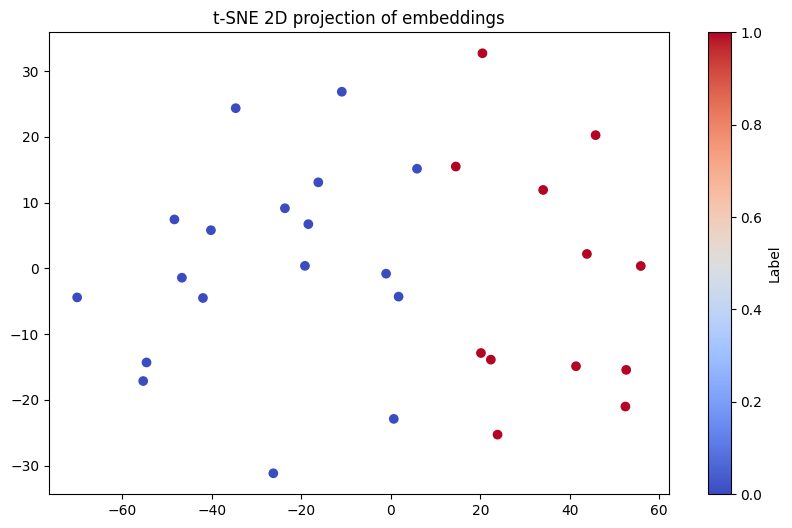

/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/Lab_NLP/Lab_NLP_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


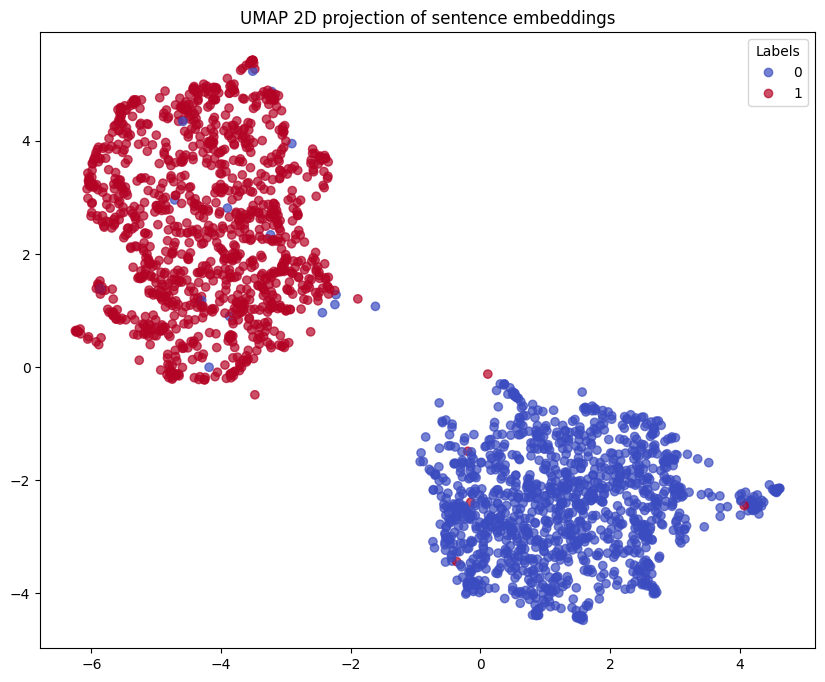


Query sentence: "What is the worst job you have ever worked at?"
Top similar sentences:
- "What's the absolute worst thing you've ever done to someone?" (label=0.0, similarity=0.705)
- "What's the most inappropriate thing you've done at work?" (label=0.0, similarity=0.666)
- "What reason would make you quit your job?" (label=0.0, similarity=0.635)
- "What's the stupidest reason for which someone has deemed you unqualified to do a piece of work?" (label=0.0, similarity=0.612)
- "What's the worst thing you experienced on any form of public transportation?" (label=0.0, similarity=0.599)

Query sentence: Sudden and consistent nocturnal enuresis. How concerned should I be?
Top similar sentences:
- Why am I suddenly pissing and shitting myself at night? (label=1.0, similarity=0.538)
- Urinary issues.. any ideas of what this is? (label=1.0, similarity=0.462)
- Recurring bladder infections, don't know what to do (label=1.0, similarity=0.455)
- Experienced something odd last night. Sleep disor

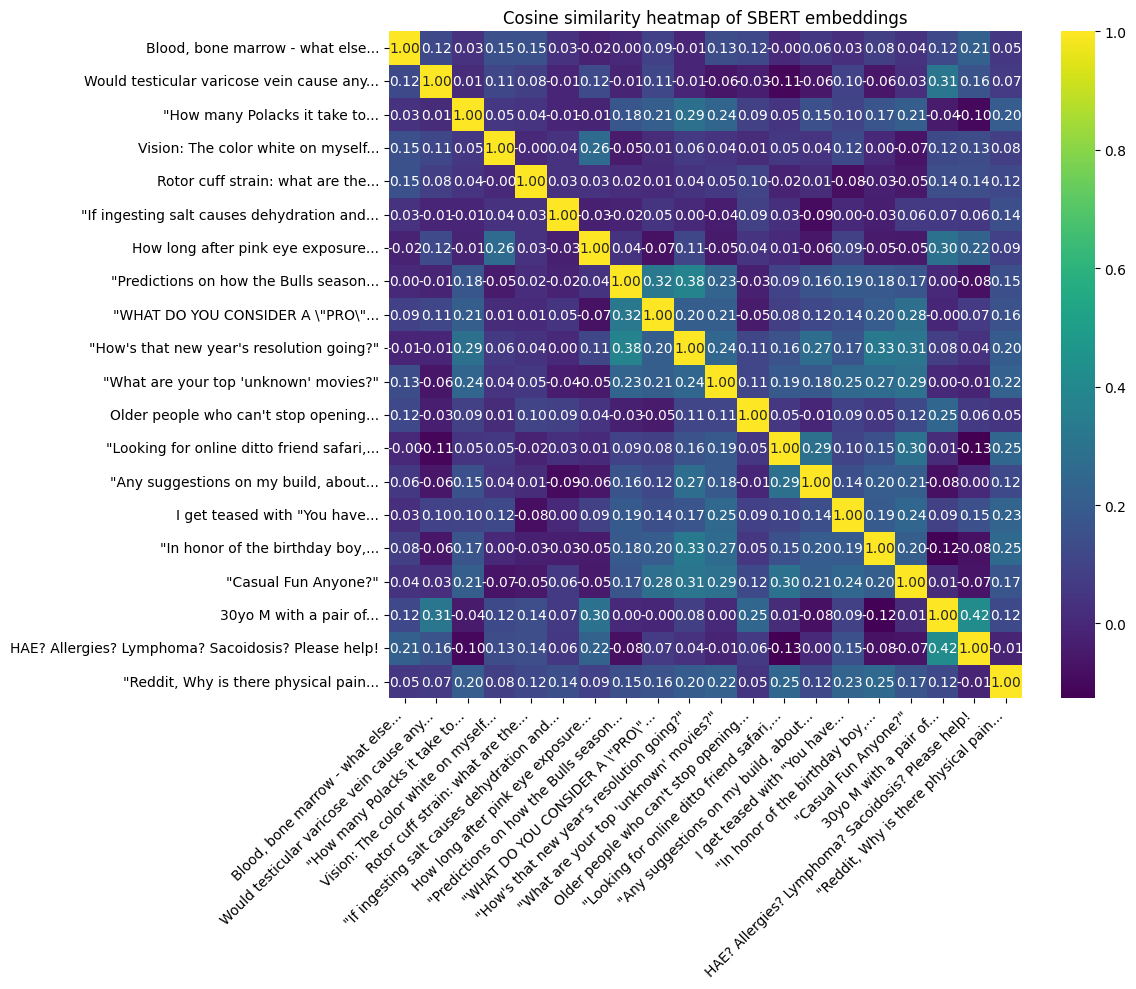

In [3]:

X_train = np.load("../data/processed/X_train.npy", allow_pickle=True)
y_train = np.load("../data/processed/y_train.npy", allow_pickle=True)

# Show the first 5 rows
for i in range(5):
    print(f"Label: {y_train[i]} | Sentence: {X_train[i]}")


from sklearn.manifold import TSNE

def display_some_examples(examples_emb, labels, n_examples):
    tsne = TSNE(n_components=2, random_state=42)
    examples_2d = tsne.fit_transform(examples_emb)

    plt.figure(figsize=(10,6))
    plt.scatter(examples_2d[:n_examples,0], examples_2d[:n_examples,1], c=labels[:n_examples], cmap='coolwarm')
    plt.colorbar(label='Label')
    plt.title("t-SNE 2D projection of embeddings")
    plt.show()

display_some_examples(X_embeddings_train, y_train, n_examples=30)

import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_emb_2d = reducer.fit_transform(X_embeddings_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=y_train, cmap='coolwarm', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Labels")
plt.title("UMAP 2D projection of sentence embeddings")
plt.show()

from sklearn.metrics.pairwise import cosine_similarity

n_queries = 3
random_indices = np.random.choice(len(X_embeddings_train), size=n_queries, replace=False)

for query_idx in random_indices:
    query_vec = X_embeddings_train[query_idx]

    # Compute cosine similarity with all embeddings
    sim_scores = cosine_similarity([query_vec], X_embeddings_train)[0]

    # Get top 5 most similar sentences (excluding the query itself)
    closest_idx = np.argsort(sim_scores)[-6:]  
    closest_idx = closest_idx[closest_idx != query_idx]  # remove the query itself

    # Print results
    print(f"\nQuery sentence: {X_train[query_idx]}")
    print("Top similar sentences:")
    for idx in closest_idx[::-1]:
        print(f"- {X_train[idx]} (label={y_train[idx]}, similarity={sim_scores[idx]:.3f})")

import seaborn as sns

# ---- Sample a subset ----
num_samples = 20  # pick how many sentences to visualize
subset_idx = np.random.choice(len(X_embeddings_train), num_samples, replace=False)
subset_embeddings = X_embeddings_train[subset_idx]
subset_sentences = X_train[subset_idx]

# ---- Compute cosine similarity ----
sim_matrix = cosine_similarity(subset_embeddings)

# ---- Prepare labels for the heatmap ----
# Use first ~6-10 words of each sentence for readability
subset_labels = [(" ".join(s.split()[:6]) + "...") if len(s.split()) > 6 else s for s in subset_sentences]

# ---- Plot the heatmap ----
plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='viridis', xticklabels=subset_labels, yticklabels=subset_labels)
plt.title("Cosine similarity heatmap of SBERT embeddings")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/Lab_NLP/Lab_NLP_venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


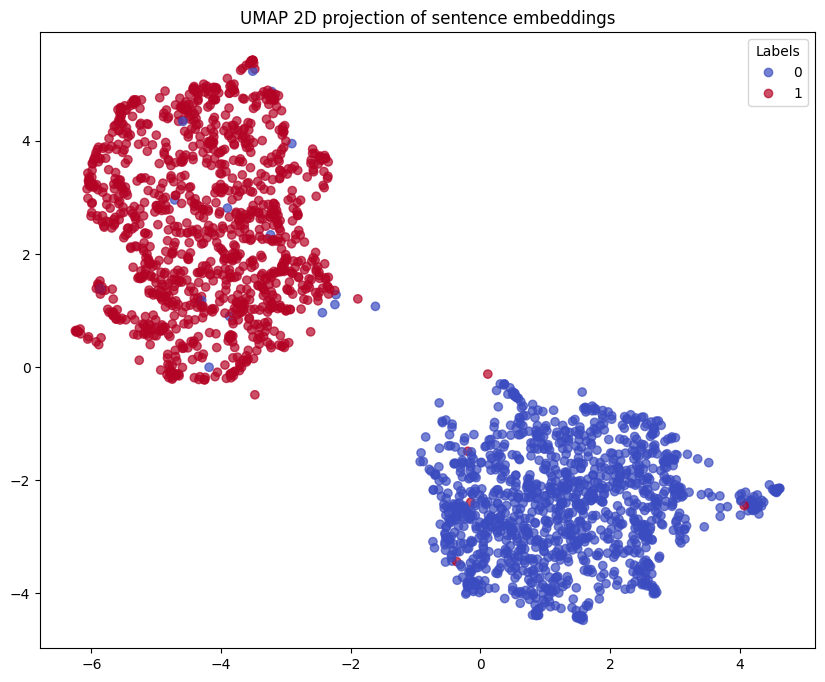

Number of misclustered points: 20

Label: 0.0, Cluster: 1
Sentence: "First psychologist appointment is in two days. Any advice?"
---
Label: 0.0, Cluster: 1
Sentence: "I stand and talk on the phone all day in a medical setting. My neck is beginning to really bother me. Does anyone have any recommendations for a small bluetooth headset?"
---
Label: 0.0, Cluster: 1
Sentence: "ELI5: why does my back itch like crazy after a shower?"
---
Label: 0.0, Cluster: 1
Sentence: "If ingesting salt causes dehydration and dehydration causes low blood pressure, why are people with high blood pressure told to avoid sodium? Wouldn't it lower their blood pressure?"
---
Label: 1.0, Cluster: 0
Sentence: What does neoplasm of uncertain behavior mean?
---
Label: 0.0, Cluster: 1
Sentence: "LPT request!! Any advice on annoying deodorant stains anyone??"
---
Label: 0.0, Cluster: 1
Sentence: "[neuroscience] (and also medicine) Has anyone ever woken up from actual \"Brain Death\"?"
---
Label: 0.0, Cluster: 1
Senten

In [4]:
import umap
from sklearn.cluster import KMeans

reducer = umap.UMAP(n_components=2, random_state=42)
X_emb_2d = reducer.fit_transform(X_embeddings_train)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_emb_2d[:, 0], X_emb_2d[:, 1], c=y_train, cmap='coolwarm', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Labels")
plt.title("UMAP 2D projection of sentence embeddings")
plt.show()

# --- Create DataFrame with coordinates and labels ---
umap_df = pd.DataFrame(X_emb_2d, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = y_train

# --- Cluster the UMAP points ---
kmeans = KMeans(n_clusters=2, random_state=42)
umap_df['cluster'] = kmeans.fit_predict(X_emb_2d)


# --- Find misclustered points (label != cluster) ---
misclustered = umap_df[umap_df['label'] != umap_df['cluster']]

print(f"Number of misclustered points: {len(misclustered)}\n")

# --- Inspect the misclustered sentences ---
mis_idx = misclustered.index
for i in mis_idx[:20]:  # show first 10 for brevity
    print(f"Label: {y_train[i]}, Cluster: {umap_df.loc[i, 'cluster']}")
    print(f"Sentence: {X_train[i]}")
    print("---")

from sklearn.metrics import silhouette_score


# --- Cluster in high-D space ---
kmeans_hd = KMeans(n_clusters=2, random_state=42)
clusters_hd = kmeans_hd.fit_predict(X_embeddings_train)

# --- Compute silhouette score ---
score = silhouette_score(X_embeddings_train, clusters_hd, metric='cosine')  # cosine is better for embeddings
print(f"Silhouette Score (high-D embeddings): {score:.4f}")



the silhouette score being near 0 indicates overlapping clusters in high dimensional space (-1 is worst value, 1 is best value)

***
# **BASE TRAINING**

In [5]:
##########################
### Set some variables ###
##########################

input_size = X_embeddings_train.shape[1]  # e.g., 384 for SBERT 
batch_size = 64 # reduce to 32 if accuracy is low
epochs = 6 #maybe increase but could overfit
n_classes = 2 #binary classification
epsilon = 0.3
alpha = 0.1
num_iter = 10

In [6]:
############################
### Pre-process the data ###
############################
#scaling not required as normally for images, as already have floating points in embeddings
#scales pixel intensities
#X_train = X_train.astype('float32') / 255
#X_test = X_test.astype('float32') / 255

#flattens image into a vector
#X_embeddings_train = np.array(X_train).reshape(X_embeddings_train.shape[0], input_size)
#X_embeddings_test = np.array(X_test).reshape(X_embeddings_test.shape[0], input_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_embeddings_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_embeddings_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [7]:
########################
### Define the model ###
########################
# could add more or denser layers (dense(256)) or switch to CNN,  or try softmax for multi-class, or add regularisation
#Marco's paper says they train a medium-sized fully-connected DNN (with 2 layers of size (128, 2) and input size 30) using stochastic gradient descent and cross-entropy loss
def get_model(input_size):
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(input_size,), name='input_features'),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
            tf.keras.layers.Dense(2, activation='softmax', kernel_initializer=initializer, name='output_layer')
        ])
    print(model.summary())
    return model

### supposedly fine with sigmoid and one output but makes no sense to me
# def get_model(input_size):
#     initializer = tf.keras.initializers.GlorotUniform(seed=42)
#     model = tf.keras.Sequential([
#             tf.keras.layers.Input(shape=(input_size,), name='input_features'),
#             tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, name='dense_1'),
#             tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, name='output_layer')
#         ])
#     print(model.summary())
#     return model

In [8]:
##########################
### Train a base model ###
##########################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

model_base = get_model(input_size)
model_base.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_fn])
model_base.fit(train_dataset, epochs=epochs, validation_data=test_dataset,)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,538 (193.51 KB)

 Trainable params: 49,538 (193.51 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6


/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/Lab_NLP/Lab_NLP_venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.1270 - val_sparse_categorical_accuracy: 0.9863
Epoch 2/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0458 - val_sparse_categorical_accuracy: 0.9880
Epoch 3/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0315 - val_sparse_categorical_accuracy: 0.9914
Epoch 4/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9949 - val_loss: 0.0264 - val_sparse_categorical_accuracy: 0.9914
Epoch 5/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0140 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0234 - val_sparse_categorical_accuracy: 0.9914
Epoch 6/6
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0221 - val_sparse_categorical_accuracy: 0.9914


In [9]:
def print_metrics(model, x, y, n_classes):
    """
    Print accuracy, precision, recall, F1, and plot ROC curves.
    Works for both binary and multiclass classification.
    """
    # Predict probabilities
    y_pred_prob = model.predict(x)
    
    # Predicted class labels
    y_pred_class = np.argmax(y_pred_prob, axis=1)
    
    # Accuracy, Precision, Recall, F1
    accuracy = accuracy_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class, average='macro')
    recall = recall_score(y, y_pred_class, average='macro')
    f1 = f1_score(y, y_pred_class, average='macro')
    
    print("=== Classification Metrics ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred_class))
    
    # ROC curve
    plt.figure(figsize=(6, 5))
    
    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y, y_pred_prob[:, 1])
        auc_score = roc_auc_score(y, y_pred_prob[:, 1])
        plt.plot(fpr, tpr, label=f'Class 1 (AUC = {auc_score:.2f})')
    else:
        # Multiclass
        y_bin = label_binarize(y, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
            auc_score = roc_auc_score(y_bin[:, i], y_pred_prob[:, i])
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()


(None, 384)
(None, 2)
(584, 384)
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
=== Classification Metrics ===
Accuracy: 0.9914
Precision (macro): 0.9913
Recall (macro): 0.9917
F1-score (macro): 0.9914

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       300
         1.0       0.98      1.00      0.99       284

    accuracy                           0.99       584
   macro avg       0.99      0.99      0.99       584
weighted avg       0.99      0.99      0.99       584



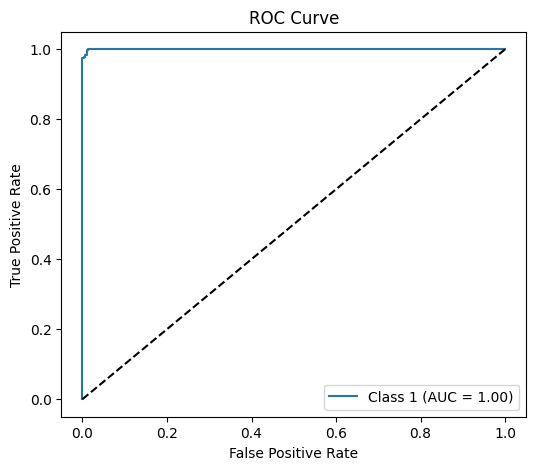

In [10]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print(model_base.input_shape)
print(model_base.output_shape)
print(X_embeddings_test.shape)

print_metrics(model_base, X_embeddings_test, y_test, n_classes)

In [11]:
######################################
### Define the PGD attack function ###
######################################

def pgd_attack(model, x, y, epsilon, alpha, num_iter):
    """Perform PGD attack on a batch of images.
    
    Args:
        model: Trained Keras model.
        x: Input images (batch).
        y: True labels (batch).
        epsilon: Maximum perturbation.
        alpha: Step size for each iteration.
        num_iter: Number of PGD iterations.

    Returns:
        Adversarial examples.
    """
    # Make a copy of the input to avoid modifying the original data
    x_adv = tf.identity(x)

    # Iterate PGD for num_iter steps
    for i in range(num_iter):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)  # Watch x_adv for gradient computation
            predictions = model(x_adv)  # Forward pass
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)  # Loss w.r.t. true label

        # Compute the gradients of the loss w.r.t. the input
        gradients = tape.gradient(loss, x_adv)
        
        # Perform gradient ascent step in the direction that maximizes the loss
        perturbations = tf.sign(gradients)  # Use the sign of the gradients (FGSM-like step)
        x_adv = x_adv + alpha * perturbations  # Update the adversarial example
        
        # Project the adversarial example to ensure it's within epsilon-ball of the original image
        x_adv = tf.clip_by_value(x_adv, x - epsilon, x + epsilon)
        
        # Ensure the adversarial examples are within the valid input range [0, 1]
        x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    
    return x_adv

In [ ]:
### from ANTONIO
def train_adversarial(model, train_dataset, test_dataset, hyperrectangles, epochs, batch_size, n_samples, pgd_steps, alfa=1, beta=1, eps_multiplier=1000, seed=None, from_logits=False):
    if seed:
        tf.random.set_seed(seed)
        np.random.seed(seed)

    optimizer = keras.optimizers.Adam()
    ce_batch_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
    pgd_batch_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)
    pgd_attack_single_image_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits)

    train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    test_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=from_logits)
    test_loss_metric = keras.metrics.SparseCategoricalCrossentropy(from_logits=from_logits)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for x_batch_train, y_batch_train in train_dataset:
            # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                outputs = model(x_batch_train, training=True)  # Outputs for this minibatch
                ce_loss_value = ce_batch_loss(y_batch_train, outputs)
                ce_loss_value = ce_loss_value * alfa
            # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(ce_loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        #########################################PGD####################################################
        pgd_dataset = []
        np.random.shuffle(hyperrectangles)
        for hyperrectangle in hyperrectangles[:n_samples]:
            t_hyperrectangle = np.transpose(hyperrectangle)

            # Calculate the epsilon for each dimension as ((dim[1] - dim[0]) / (pgd_steps * eps_multiplier))
            eps = []
            for d in hyperrectangle:
                eps.append((d[1] - d[0]) / (pgd_steps * eps_multiplier))
            
            # Generate a pgd point from the hyperrectangle 
            pgd_point = []
            for d in hyperrectangle:
                pgd_point.append(np.random.uniform(d[0], d[1]))
            # PGD attack on the image
            pgd_point = tf.convert_to_tensor([pgd_point], dtype=tf.float32)
            label_0 = tf.convert_to_tensor([[0]], dtype=tf.float32)
            for pgd_step in range(pgd_steps):
                with tf.GradientTape() as tape:
                    tape.watch(pgd_point)
                    prediction = model(pgd_point, training=False)
                    pgd_single_image_loss = pgd_attack_single_image_loss(label_0, prediction)
                # Get the gradients of the loss w.r.t to the input image.
                gradient = tape.gradient(pgd_single_image_loss, pgd_point)
                # Get the sign of the gradients to create the perturbation
                signed_grad = tf.sign(gradient)
                pgd_point = pgd_point + signed_grad * eps
                pgd_point = tf.clip_by_value(pgd_point, t_hyperrectangle[0], t_hyperrectangle[1])
                # print(f"PGD step: {pgd_step + 1}", end="\r")

            # Concatenate the pgd points
            if len(pgd_dataset) > 0:
                pgd_dataset = np.concatenate((pgd_dataset, pgd_point), axis=0)
            else:
                pgd_dataset = pgd_point

        pgd_dataset = np.asarray(pgd_dataset)
        pgd_labels_inside = np.full(len(pgd_dataset), 0)

        # Convert the pgd generated inputs into tf datasets, shuffle and batch them
        pgd_dataset = tf.data.Dataset.from_tensor_slices((pgd_dataset, pgd_labels_inside))
        pgd_dataset = pgd_dataset.shuffle(buffer_size=1024).batch(batch_size)

        # Iterate over the batches of the pgd dataset.
        for x_batch_train, y_batch_train in pgd_dataset:
            # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
                outputs = model(x_batch_train, training=True)  # Outputs for this minibatch
                pgd_loss_value = pgd_batch_loss(y_batch_train, outputs)
                pgd_loss_value = pgd_loss_value * beta
            # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(pgd_loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        ################################################################################################
        
        # Run a training loop at the end of each epoch.
        for x_batch_train, y_batch_train in train_dataset:
            train_outputs = model(x_batch_train, training=False)
            train_acc_metric.update_state(y_batch_train, train_outputs)
            train_loss_metric.update_state(y_batch_train, train_outputs)

        # Run a testing loop at the end of each epoch.
        for x_batch_test, y_batch_test in test_dataset:
            test_outputs = model(x_batch_test, training=False)
            test_acc_metric.update_state(y_batch_test, test_outputs)
            test_loss_metric.update_state(y_batch_test, test_outputs)

        train_acc = train_acc_metric.result()
        test_acc = test_acc_metric.result()
        train_loss = train_loss_metric.result()
        test_loss = test_loss_metric.result()

        train_acc_metric.reset_states()
        test_acc_metric.reset_states()
        train_loss_metric.reset_states()
        test_loss_metric.reset_states()

        print(f"Train acc: {float(train_acc):.4f}, Train loss: {float(train_loss):.4f} --- Test acc: {float(test_acc):.4f}, Test loss: {float(test_loss):.4f} --- Time: {(time.time() - start_time):.2f}s")

    return model


We need to conduct perturbations of the sentences - using moradi for example https://github.com/mmoradi-iut/NLP-perturbation
and vicuna and/or other types of perturbation methods

also are complete scripts available on ANTONIO toolbox with perturbations and definitions of hyper-rectangles https://github.com/ANTONIONLP/ANTONIO/tree/main

In [12]:
############################################################################
### Define the function to visualize the original and adversarial images ###
############################################################################

def original_vs_adversarial_images(x_og, y_og, x_adv, y_pred):
    plt.figure(figsize=(17, 4))

    # Counter for how many images to display
    display_count = 0

    for i in range(len(x_og)):
        # Check if the class changes after the attack
        if y_og[i] != y_pred[i]:
            # Original images (reshape from (28, 28, 1) to (28, 28))
            original_image = x_og[i].reshape(28, 28)
            
            # Adversarial images (reshape from (28, 28, 1) to (28, 28))
            adversarial_image = x_adv[i].numpy().reshape(28, 28)

            # Plot original images
            plt.subplot(2, 10, display_count + 1)
            plt.imshow(original_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Orig: {y_og[i]}')

            # Plot adversarial images
            plt.subplot(2, 10, display_count + 11)
            plt.imshow(adversarial_image, cmap='gray')
            plt.axis('off')
            plt.title(f'Adv: {y_pred[i]}')

            # Increment the display counter
            display_count += 1
            
            # Stop after displaying 10 images
            if display_count == 10:
                break

    plt.tight_layout()
    plt.show()

In [13]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample = X_embeddings_test
y_test_sample = y_test

# Generate adversarial examples
x_test_adv = pgd_attack(model_base, x_test_sample, y_test_sample, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv = np.argmax(model_base.predict(x_test_adv), axis=1)
accuracy_adv = np.mean(y_pred_adv == y_test_sample)

print(f'Accuracy on adversarial examples: {accuracy_adv:.4f}')
original_vs_adversarial_images(x_test_sample, y_test_sample, x_test_adv, y_pred_adv)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
Accuracy on adversarial examples: 0.0000


ValueError: cannot reshape array of size 384 into shape (28,28)

<Figure size 1700x400 with 0 Axes>

***
# **ADVERSARIAL TRAINING**

In [25]:
################################################
### Define the adversarial training function ###
################################################

def adversarial_training(model, train_dataset, optimizer, loss_fn, epsilon, alpha, num_iter, epochs):
    """
    Performs adversarial training with PGD adversarial examples.
    
    Args:
    model: The model to train.
    train_dataset: A TensorFlow dataset for training.
    optimizer: The optimizer for model training.
    loss_fn: Loss function to use.
    epsilon: Maximum perturbation for PGD (epsilon).
    alpha: Step size for PGD.
    num_iter: Number of PGD iterations for generating adversarial examples.
    epochs: Number of training epochs.
    
    Returns:
    model: The trained model.
    """
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for the epoch
        print(f"Epoch {epoch + 1}/{epochs}")

        # Accuracy metric for the epoch
        train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        
        # Training loop over batches
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Generate adversarial examples using PGD
                x_adv_batch = pgd_attack(model, x_batch, y_batch, epsilon=epsilon, alpha=alpha, num_iter=num_iter)
                
                # Combine original and adversarial examples for training
                combined_x = tf.concat([x_batch, x_adv_batch], axis=0)
                combined_y = tf.concat([y_batch, y_batch], axis=0)
                
                # Forward pass
                logits = model(combined_x, training=True)
                
                # Compute the loss
                loss = loss_fn(combined_y, logits)
            
            # Backpropagation
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training accuracy metric
            train_acc_metric.update_state(combined_y, logits)

        # End of epoch: calculate and print accuracy and epoch time
        train_acc = train_acc_metric.result().numpy()

        # Evaluate on test dataset (for validation accuracy)
        test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
        for x_test_batch, y_test_batch in test_dataset:
            test_logits = model(x_test_batch, training=False)
            test_acc_metric.update_state(y_test_batch, test_logits)
        test_acc = test_acc_metric.result().numpy()

        print(f"Train loss: {loss.numpy():.4f} -|- Train acc: {train_acc:.4f} -|- Test acc: {test_acc:.4f} -|- Time: {(time.time() - start_time):.2f}s")
    
    return model

In [26]:
##################################
### Train an adversarial model ###
##################################

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_adv = get_model(input_size)
model_adv = adversarial_training(model_adv, train_dataset, optimizer, loss_fn, epsilon=epsilon, alpha=alpha, num_iter=num_iter, epochs=epochs)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/6


2025-09-16 20:51:14.392380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-16 20:51:14.801875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.1367 -|- Train acc: 0.8585 -|- Test acc: 0.9458 -|- Time: 74.95s
Epoch 2/6


2025-09-16 20:52:30.796347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.2838 -|- Train acc: 0.9302 -|- Test acc: 0.9637 -|- Time: 75.99s
Epoch 3/6
Train loss: 0.1352 -|- Train acc: 0.9452 -|- Test acc: 0.9707 -|- Time: 76.64s
Epoch 4/6


2025-09-16 20:55:04.364581: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train loss: 0.1291 -|- Train acc: 0.9541 -|- Test acc: 0.9719 -|- Time: 76.93s
Epoch 5/6
Train loss: 0.0425 -|- Train acc: 0.9601 -|- Test acc: 0.9747 -|- Time: 77.05s
Epoch 6/6
Train loss: 0.0449 -|- Train acc: 0.9639 -|- Test acc: 0.9760 -|- Time: 76.79s


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Accuracy: 0.9760
Precision (macro): 0.9757
Recall (macro): 0.9759
F1-score (macro): 0.9757


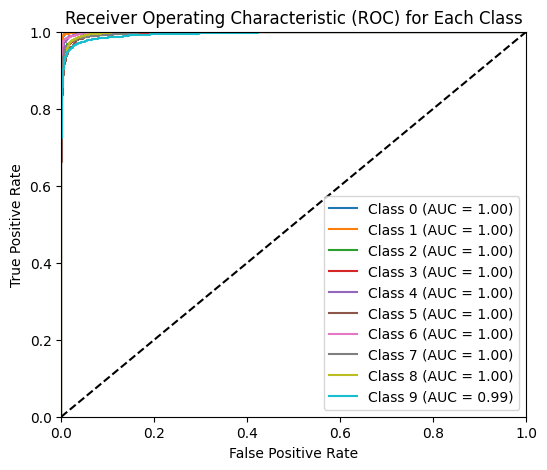

In [27]:
#####################################################
### Calculate precision, recall, F1 and ROC curve ###
#####################################################

print_metrics(model_adv, X_test, y_test, n_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
Accuracy on adversarial examples: 0.9405


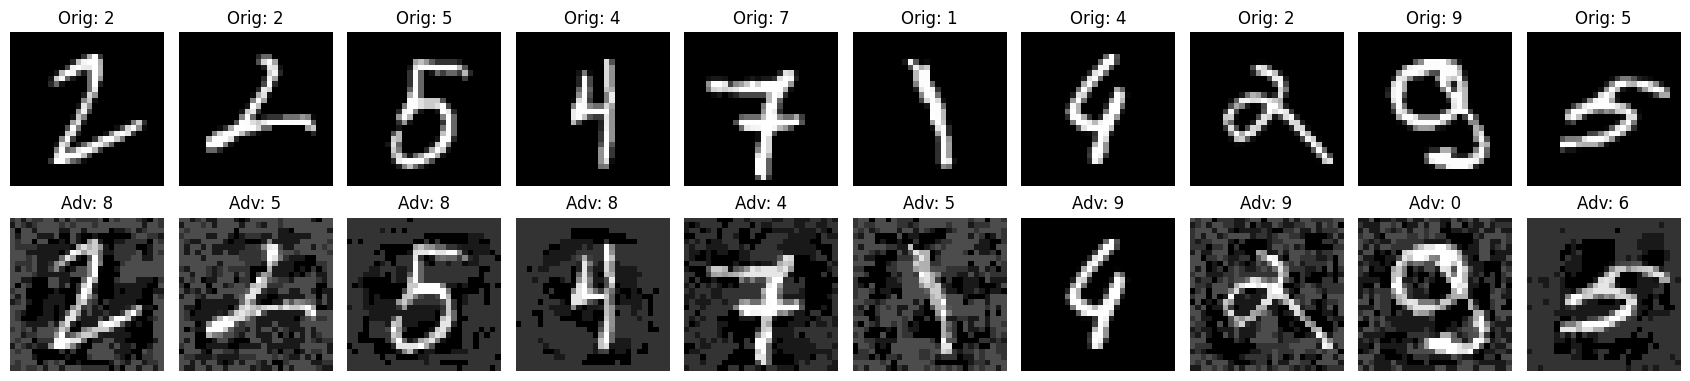

In [28]:
####################################################################################
### Attack the model using PGD and visualize the original and adversarial images ###
####################################################################################

# Test the PGD attack
x_test_sample_ADV = X_test
y_test_sample_ADV = y_test

# Generate adversarial examples
x_test_adv_ADV = pgd_attack(model_adv, x_test_sample_ADV, y_test_sample_ADV, epsilon=epsilon, alpha=alpha, num_iter=num_iter)

# Evaluate the model on the adversarial examples
y_pred_adv_ADV = np.argmax(model_adv.predict(x_test_adv_ADV), axis=1)
accuracy_adv_ADV = np.mean(y_pred_adv_ADV == y_test_sample_ADV)

print(f'Accuracy on adversarial examples: {accuracy_adv_ADV:.4f}')
original_vs_adversarial_images(x_test_sample_ADV, y_test_sample_ADV, x_test_adv_ADV, y_pred_adv_ADV)

In [29]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize explainer
explainer = lime_image.LimeImageExplainer()

# Pick a test image to explain
i = 0
image = X_test[i]  # shape (28,28)
label = y_test[i]

# LIME expects 3-channel images; MNIST is grayscale
image_3ch = np.stack([image]*3, axis=-1)

# Explain the image
explanation = explainer.explain_instance(
    image_3ch,
    classifier_fn=lambda x: model_adv.predict(x.reshape(-1, input_size).astype('float32')),
    top_labels=3,
    hide_color=0,
    num_samples=1000
)

# Get superpixel explanation for top predicted class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

# Display
plt.imshow(mark_boundaries(temp, mask))
plt.title(f'True label: {label}, Predicted: {np.argmax(model_adv.predict(image_3ch.reshape(1,-1)))}')
plt.axis('off')
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1000, 9000]